# Anchored CorEx: Topic Modeling with Minimal Domain Knowledge

**Author:** [Ryan J. Gallagher](http://ryanjgallagher.github.io/)  

**Last updated:** 07/21/2018

This notebook walks through how to use the CorEx topic model code. This includes fitting CorEx to your data, examining the topic model output, outputting results, building a hierarchical topic model, and anchoring words to topics.

Details of the CorEx topic model and evaluations against unsupervised and semi-supervised variants of LDA can be found in our TACL paper:

Gallagher, Ryan J., Kyle Reing, David Kale, and Greg Ver Steeg. "[Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244)." *Transactions of the Association for Computational Linguistics (TACL)*, 2017.

In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pandas as pd
from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

## Loading the 20 Newsgroups Dataset

We need to first load data to run the CorEx topic model. We'll use the 20 Newsgroups dataset, which scikit-learn provides functionality to access.

In [24]:
data_df = pd.read_pickle('./pickles/dtm_idf.pickle')
# data_df.transpose()
data_df = data_df.transpose()
data_df['index'] = data_df.index

data_df

,ama,askreddit,dankmemes,funny,memes,science,worldnews,wsb,index
aa,0.0,0.000464,0.0,0.0,0.000000,0.0,0.000519,0.0,aa
aaa,0.0,0.000184,0.0,0.0,0.000000,0.0,0.000000,0.0,aaa
aaaaa,0.0,0.000000,0.0,0.0,0.001659,0.0,0.000000,0.0,aaaaa
aaaaaaaa,0.0,0.000061,0.0,0.0,0.000000,0.0,0.000000,0.0,aaaaaaaa
aaaaaaaaaaaa,0.0,0.000052,0.0,0.0,0.000000,0.0,0.000259,0.0,aaaaaaaaaaaa
...,...,...,...,...,...,...,...,...,...
𝙄𝙏,0.0,0.000061,0.0,0.0,0.000000,0.0,0.000000,0.0,𝙄𝙏
𝙏𝙃𝙀,0.0,0.000123,0.0,0.0,0.000000,0.0,0.000000,0.0,𝙏𝙃𝙀
𝙔𝙀𝙎,0.0,0.000061,0.0,0.0,0.000000,0.0,0.000000,0.0,𝙔𝙀𝙎
𝚃𝚑𝚒𝚜,0.0,0.000000,0.0,0.0,0.001659,0.0,0.000000,0.0,𝚃𝚑𝚒𝚜


In [26]:
for i, row in enumerate(data_df['index']):
    candidate = re.match('a{2,}', str(row))
    if candidate != None:
        data_df.drop(row, inplace=True)
    if row == 'ababababba':
        data_df.drop(row, inplace=True)
    if row == 'wa':
        data_df.drop(row, inplace=True)       
    if row == 'ha':
        data_df.drop(row, inplace=True)    
data_df.drop(columns=['index'])

,ama,askreddit,dankmemes,funny,memes,science,worldnews,wsb
ab,0.000000,0.000311,0.000000,0.000000,0.000000,0.001261,0.000000,0.000561
aba,0.000000,0.000123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aback,0.000000,0.000078,0.000000,0.000000,0.000000,0.000553,0.000196,0.000492
abandon,0.001758,0.000552,0.000000,0.000780,0.000000,0.000000,0.000695,0.000435
abandoned,0.002797,0.000741,0.000964,0.001241,0.000740,0.000389,0.001105,0.000000
...,...,...,...,...,...,...,...,...
𝙄𝙏,0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
𝙏𝙃𝙀,0.000000,0.000123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
𝙔𝙀𝙎,0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
𝚃𝚑𝚒𝚜,0.000000,0.000000,0.000000,0.000000,0.001659,0.000000,0.000000,0.000000


In [16]:
# Get 20 newsgroups data
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [2]:
data_df = pd.read_pickle('askreddit_lemmatized.pickle')
lis = data_df[0].tolist()
lis

['victorias secret originally suppose place man buy lingerie wife feel embarrassed exclusively shop woman',
 'ford mustang   suppose car big trunk fit grocery   ad article state mustang match color lipstick   make sense lot old mustang red',
 'heel remember correctly',
 'family feud get new question answer',
 'skirt wear battle man room',
 'ugg boot originally wear male surfer girlfriend steal wear like leather jacket',
 'filter cigarette general marlboro big leap term gendere marketing conspiracy theory come like cigarette idk bad people switch filter cigarette filter mean good time salt earth classic american marlboro man come existence try distance brand previously woman focus advertisement',
 'leg stirrup use gynocologist invent remove kidney stone man cut testicle cut right prostate low survival rate approve medical profession    original hippocratic oath section cut stone meaning swear surgically remove kidney stone later remove section oath bunch urologist job',
 'hoodie apparen

The topic model assumes input is in the form of a doc-word matrix, where rows are documents and columns are binary counts. We'll vectorize the newsgroups data, take the top 20,000 words, and convert it to a sparse matrix to save on memory usage. Note, we use binary count vectors as input to the CorEx topic model.

In [3]:
# Transform 20 newsgroup data into a sparse matrix
vectorizer = CountVectorizer(max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(lis)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(101141, 20000)

Our doc-word matrix is 11,314 documents by 20,000 words. Let's get the words that label the columns. We'll need these for outputting readable topics and later for anchoring.

In [4]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))
words

['aa',
 'aaa',
 'aaaaaand',
 'aaaaand',
 'aaaah',
 'aaaand',
 'aaand',
 'aang',
 'aaron',
 'aarp',
 'ab',
 'aba',
 'aback',
 'abandon',
 'abandonment',
 'abbey',
 'abbreviation',
 'abby',
 'abc',
 'abdicate',
 'abduct',
 'abdul',
 'abe',
 'abed',
 'abel',
 'abercrombie',
 'aberdolf',
 'abernathy',
 'abhorrent',
 'abide',
 'abigail',
 'abilify',
 'ability',
 'abject',
 'ablaze',
 'able',
 'ableism',
 'ableton',
 'abnormal',
 'aboard',
 'abolish',
 'abolitionist',
 'abomination',
 'abort',
 'abortion',
 'about',
 'abracadabra',
 'abradolf',
 'abradolph',
 'abraham',
 'abrahamic',
 'abrahams',
 'abrams',
 'abrasive',
 'abredolf',
 'abridge',
 'abroad',
 'abrodolph',
 'abrupt',
 'abruptly',
 'abs',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absolutist',
 'absolutly',
 'absolve',
 'absorb',
 'absorbent',
 'abstain',
 'abstinence',
 'abstinent',
 'abstract',
 'absurd',
 'absurdity',
 'absurdly',
 'abt',
 'abundance',
 'abundant',
 'abundantly',
 'abuse',
 'abused',
 'ab

We'll do a final step of preprocessing where we remove all integers from our set of words. This brings is down to 19,038 words.

In [30]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(9, 9)

## CorEx Topic Model

The main parameters of the CorEx topic model are:
+ **`n_hidden`**: number of topics ("hidden" as in "hidden latent topics")
+ **`words`**: words that label the columns of the doc-word matrix (optional)
+ **`docs`**: document labels that label the rows of the doc-word matrix (optional)
+ **`max_iter`**: number of iterations to run through the update equations (optional, defaults to 200)
+ **`verbose`**:  if `verbose=1`, then CorEx will print the topic TCs with each iteration
+ **`seed`**:     random number seed to use for model initialization (optional)

We'll train a topic model with 50 topics. (This will take a few minutes.)

In [5]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=50, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

## CorEx Output

### Topics

The CorEx topic model provides functionality for easily accessing the topics. Let's take a look one of the topics.

In [34]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=1, n_words=10)

[('ama', 0.4421466765550526)]

The topic words are those with the highest *mutual information* with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from **`get_topics()`**, then the absolute value of that quantity is the mutual information between the topic and the *absence* of that word.

If the column labels have not been specified through **`words`**, then the code will return the column indices for the top words in each topic.

We can also retrieve all of the topics at once if we would like.

In [36]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
#     topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: science
1: science
2: science
3: science
4: science
5: science
6: science
7: science
8: science
9: science
10: science
11: science
12: science
13: science
14: science
15: science
16: science
17: science
18: science
19: science
20: science
21: science
22: science
23: science
24: science
25: science
26: science
27: science
28: science
29: science
30: science
31: science
32: science
33: science
34: science
35: science
36: science
37: science
38: science
39: science
40: science
41: science
42: science
43: science
44: science
45: science
46: science
47: science
48: science
49: science


The first topic for the newsgroup data tends to be less coherent than expected because of encodings and other oddities in the newsgroups data.  

We can also get the column indices instead of the column labels if necessary.

In [37]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(3, 0.44214544997586624)]

If we need to directly access the topic assignments for each word, they can be accessed through **`cluster`**.

In [11]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[ 8  9 38 ... 37  0  0]
(19038,)


### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [12]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(3097, 0.0),
 (2350, 0.0),
 (105, 0.0),
 (3864, 0.0),
 (9396, 0.0),
 (11229, 0.0),
 (6440, 0.0),
 (6437, 0.0),
 (2284, 0.0),
 (8445, 0.0)]

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [13]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(11314, 50)


We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [14]:
print(topic_model.labels.shape) # n_docs x k_topics

(11314, 50)


Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

## Total Correlation and Model Selection

### Overall TC

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through **`tc`** and is reported in nats.

In [15]:
topic_model.tc

44.54780845461276

**Model selection:** CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

### Topic TC

The overall total correlation is the sum of the total correlation per each topic. These can be accessed through **`tcs`**. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [16]:
topic_model.tcs.shape # k_topics

(50,)

In [17]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

44.54780845461276
44.54780845461276


**Selecting number of topics:** one way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

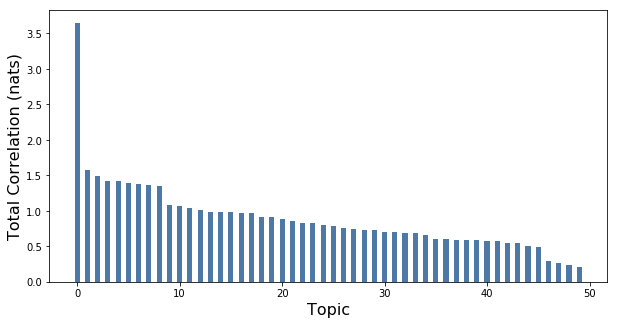

In [18]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

We see the first topic is much more informative than the other topics. Given that we suspect that this topic is picking up on image encodings (as given by "dsl" and "n3jxp" in the topic) and other boilerplate text (as given by the high TC and lack of coherence of the rest of the topic), we could consider doing additional investigation and preprocessing to help ensure that the CorEx topic model does not pick up on these patterns which are not insightful.

### Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through **`log_z`**.

In [19]:
topic_model.log_z.shape # n_docs x k_topics

(11314, 50)

In [20]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[3.64813418 1.57958569 1.48835238 1.42639341 1.42043661 1.39232446
 1.37222362 1.36535367 1.34334261 1.08793513 1.06264005 1.03767991
 1.01780633 0.98444346 0.98350034 0.97751588 0.97425573 0.96560217
 0.9170467  0.91160502 0.87920818 0.86341492 0.83259909 0.82311403
 0.79730235 0.78507652 0.76449939 0.74186846 0.73348486 0.7232203
 0.70714498 0.70407292 0.6876558  0.68271949 0.66403509 0.60590956
 0.59919508 0.58802044 0.5869777  0.58426131 0.57613847 0.57032326
 0.5434933  0.54324576 0.504955   0.48664151 0.28893956 0.27183877
 0.24173114 0.21054385]
[3.64813418 1.57958569 1.48835238 1.42639341 1.42043661 1.39232446
 1.37222362 1.36535367 1.34334261 1.08793513 1.06264005 1.03767991
 1.01780633 0.98444346 0.98350034 0.97751588 0.97425573 0.96560217
 0.9170467  0.91160502 0.87920818 0.86341492 0.83259909 0.82311403
 0.79730235 0.78507652 0.76449939 0.74186846 0.73348486 0.7232203
 0.70714498 0.70407292 0.6876558  0.68271949 0.66403509 0.60590956
 0.59919508 0.58802044 0.5869777  0.5842

The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

## Hierarchical Topic Models

The **`labels`** attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

In [21]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

If you have `graphviz` installed, then you can output visualizations of the hierarchial topic model to your current working directory. One can also create custom visualizations of the hierarchy by properly making use of the **`labels`** attribute of each layer.

In [ ]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')

## Anchoring for Semi-Supervised Topic Modeling

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.  

The anchoring mechanism is flexible, and so there are many possibilities of anchoring. We explored the following types of anchoring in our TACL paper:

1. Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

2. Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

3. Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.


We'll demonstrate how to anchor words to the the CorEx topic model and how to develop other anchoring strategies.

In [22]:
# Anchor one word to the first topic
anchor_words = ['nasa']

In [23]:
# Anchor the word 'nasa' to the first topic
anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

This anchors the single word "nasa" to the first topic.

In [24]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=0))
print('0: ' + ','.join(topic_words))

0: nasa,gov,ames,institute,jpl,station,propulsion,jsc,arc,shafer


We can anchor multiple groups of words to multiple topics as well.

In [25]:
# Anchor 'nasa' and 'space' to first topic, 'sports' and 'stadium' to second topic, so on...
anchor_words = [['nasa', 'space'], ['sports', 'stadium'], ['politics', 'government'], ['love', 'hope']]

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [26]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: space,nasa,orbit,moon,shuttle,launch,gov,earth,lunar,ames
1: sports,stadium,april,san,city,los,york,washington,angeles,center
2: government,politics,state,rights,law,war,country,military,public,security
3: hope,love,helps,relates,virile,tatoos,sustaining,whosoever,weird,allegory


Note, in the above topic model, topics will no longer be sorted according to descending TC. Instead, the first topic will be the one with "nasa" and "space" anchored to it, the second topic will be the one with "sports" and "stadium" anchored to it, and so on.  

Observe, the topic with "love" and "hope" anchored to it is less interpretable than the other three topics. This could be a sign that there is not a good topic around these two words, and one should consider if it is appropriate to anchor around them.

We can continue to develop even more involved anchoring strategies. Here we anchor "nasa" by itself, as well as in two other topics each with "politics" and "news" to find different aspects around the word "nasa". We also create a fourth anchoring of "war" to a topic.

In [27]:
# Anchor with single words and groups of words
anchor_words = ['nasa', ['nasa', 'politics'], ['nasa', 'news'], 'war']

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [28]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: nasa,space,orbit,launch,shuttle,moon,earth,lunar,satellite,commercial
1: nasa,politics,research,gov,science,scientific,institute,organization,studies,providing
2: news,nasa,insisting,edwards,hal,llnl,cso,cfv,nodak,admin
3: war,israel,armenians,armenian,israeli,jews,soldiers,military,killed,history


**Note:** If you do not specify the column labels through `words`, then you can still anchor by specifying the column indices of the features you wish to anchor on. You may also specify anchors using a mix of strings and indices if desired.

**Choosing anchor strength:** the anchor strength controls how much weight CorEx puts towards maximizing the mutual information between the anchor words and their respective topics. Anchor strength should always be set at a value *greater than* 1, since setting anchor strength between 0 and 1 only recovers the unsupervised CorEx objective. Empirically, setting anchor strength from 1.5-3 seems to nudge the topic model towards the anchor words. Setting anchor strength greater than 5 is strongly enforcing that the CorEx topic model find a topic associated with the anchor words.

We encourage users to experiment with the anchor strength and determine what values are best for their needs.

## Other Output

The **`vis_topic`** module provides support for outputting topics and visualizations of the CorEx topic model. The code below creates a results direcory named "twenty" in your working directory.

In [ ]:
vt.vis_rep(topic_model, column_label=words, prefix='twenty')

## Further Reading

Our TACL paper details the theory of the CorEx topic model, its sparsity optimization, anchoring via the information bottleneck, comparisons to LDA, and anchoring experiments. The two papers from Greg Ver Steeg and Aram Galstyan develop the CorEx theory in general and provide further motivation and details of the underlying CorEx mechanisms. Hodas et al. demonstrated early CorEx topic model results and investigated an application of pointwise total correlations to quantify "surprising" documents.

1. [Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244), Gallagher et al., TACL 2017.

2. [Discovering Structure in High-Dimensional Data Through Correlation Explanation](https://arxiv.org/abs/1406.1222), Ver Steeg and Galstyan, NIPS 2014. 

3. [Maximally Informative Hierarchical Representions of High-Dimensional Data](https://arxiv.org/abs/1410.7404), Ver Steeg and Galstyan, AISTATS 2015.

4. [Disentangling the Lexicons of Disaster Response in Twitter](https://dl.acm.org/citation.cfm?id=2741728), Hodas et al., WWW 2015.